# Disaster Tweets with NLP Kaggle Mini-Project

Hello, welcome to this project which is my submission for the Kaggle competition [NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). IF you want to see this project you can check the my GitHub repo [rorrostieta/disaster_tweets](https://github.com/rorrostieta/disaster_tweets) for more info on the libraries and the code I used to execute this project within the Kaggle kernel. Lets begin!

## The Problem
For this competition we're given a train and test dataser which contain the following information:
* id
* keyword
* location
* text (tweet)
* target (disaster)

The objective is to identidy if there is a disaster present where people are base on the words they use whether they're spending their time under te burning hot sun or maybe it is an actual emergency such as a forest fire. We will be using about 7.6K text entries which we need to handle approprietly in order to predict if a disaster is happening or not (this can be identified in the target column with a 0 NO disaster or a 1 there IS/WAS a disaster).

## Set up and Exploratory Data Analysis
I'll be using a couple sklearn libraries to split the data and evaluate the models made with keras with tensorflow backend, both of these with some well known data preprocessing libraries panda, numpy and matplotlib for visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import losses

### Importing the Data

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.info

<bound method DataFrame.info of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...

From the first looks we see we have 5 columns where `keyword` and `location` have some missing values we need to look into. Additionally the `text` field has the tweets with their respective hashtags and links which we might need to be careful with.

The strategy will be to see how many `keywords` and `locations` we have available. For the `text` side of things lets see the distribution for **number of words** and the **number of characters** these might be useful for our text analysis later.

In [5]:
print('Number of unique keywords:',len(train_data['keyword'].unique()))
print('Number of unique locations:',len(train_data['location'].unique()))

Number of unique keywords: 222
Number of unique locations: 3342


array([[<AxesSubplot:title={'center':'keyword'}>,
        <AxesSubplot:title={'center':'location'}>]], dtype=object)

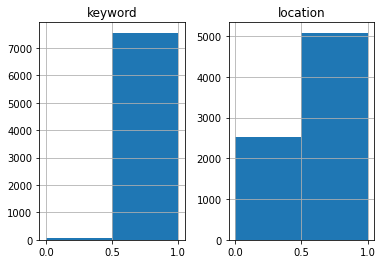

In [6]:
train_data[['keyword', 'location']].notna().astype(int).hist(bins=2)

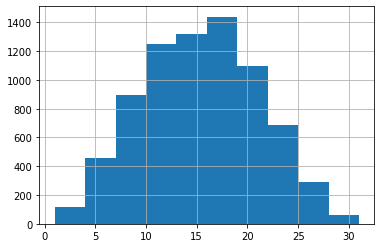

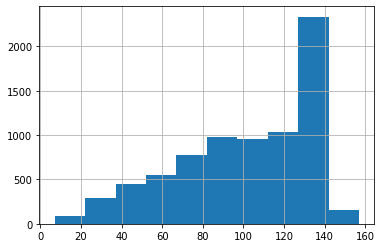

In [7]:
train_data['text'].str.split().map(len).hist()
plt.show()
train_data['text'].map(len).hist()
plt.show()

<AxesSubplot:>

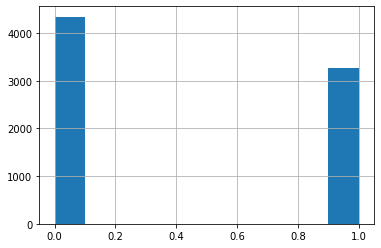

In [8]:
train_data['target'].hist()

### EDA Results
* **Dismiss `keywords` and `location`** this becasue we have only around 200s `keywords` which are integrated into the text this might be redundant information which can create bias but the opposite happends with `location` which we have a lot of values almost half of the sample size which could cause problems.
* **`Text` entries have no more than 30 words**, knowing this is important since we might need to understand out data source in this case tweets which are limited in nature allowing us to target certain amount of words.
* **Good split of Y values** this should be enough to be able to train and validate the model.

## PreProcessing

In [9]:
tweets = train_data['text'].to_numpy()
labels = train_data['target'].to_numpy()
tst_tweets = test_data['text']
trn_tweets, val_tweets, trn_labels, val_labels = train_test_split(tweets, labels, test_size=0.2, random_state=42, shuffle=True)

In [10]:
max_features = 20000
sequence_length = 50

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

2022-09-27 23:09:00.490969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 23:09:00.592045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 23:09:00.592871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 23:09:00.594523: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
vectorize_layer.adapt(trn_tweets)

2022-09-27 23:09:03.339816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
first_tweet = trn_tweets[0]
first_label = trn_labels[0]
print('Tweet', first_tweet)
print('Label', first_label)
print('Vectorized Tweet', vectorize_layer(trn_tweets[0]))

Tweet Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR
Label 1
Vectorized Tweet tf.Tensor(
[17198     8  4962  2917     6   156     5   438   216   118     4  2377
  4973  1177   240  4381  4119 14803     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int64)


In [13]:
print('Word #1 -->', vectorize_layer.get_vocabulary()[1])
print('Word #8 -->', vectorize_layer.get_vocabulary()[8])
print('Word #4962 -->', vectorize_layer.get_vocabulary()[4962])
print('Total words in training vocabulary:', len(vectorize_layer.get_vocabulary()))

Word #1 --> [UNK]
Word #8 --> and
Word #4962 --> honest
Total words in training vocabulary: 19422


In [14]:
embedding_layer = layers.Embedding(
    input_dim = max_features,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=sequence_length,
    name='mbedding_1')

In [15]:
Is = layers.Input(shape = (1,), dtype = tf.string)
L1 = vectorize_layer(Is)
L2 = embedding_layer(L1)
L3 = layers.GlobalAveragePooling1D()(L2)
Os = layers.Dense(1, activation = 'sigmoid')(L3)

model = tf.keras.Model(Is, Os, name = 'Dense_Model')
model.summary()

Model: "Dense_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
mbedding_1 (Embedding)       (None, 50, 128)           2560000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,560,129
Trainable params: 2,560,129
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)
history = model.fit(
    x=trn_tweets,
    y=trn_labels,
    epochs=15,
    validation_data=(val_tweets, val_labels)
)

Epoch 1/15
191/191 [==============================] - 3s 5ms/step - loss: 0.6661 - accuracy: 0.5852 - val_loss: 0.6382 - val_accuracy: 0.6422
Epoch 2/15
191/191 [==============================] - 1s 4ms/step - loss: 0.5761 - accuracy: 0.7458 - val_loss: 0.5504 - val_accuracy: 0.7636
Epoch 3/15
191/191 [==============================] - 1s 5ms/step - loss: 0.4607 - accuracy: 0.8389 - val_loss: 0.4922 - val_accuracy: 0.7978
Epoch 4/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3745 - accuracy: 0.8690 - val_loss: 0.4656 - val_accuracy: 0.8076
Epoch 5/15
191/191 [==============================] - 1s 5ms/step - loss: 0.3116 - accuracy: 0.8933 - val_loss: 0.4550 - val_accuracy: 0.8063
Epoch 6/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2594 - accuracy: 0.9117 - val_loss: 0.4506 - val_accuracy: 0.8070
Epoch 7/15
191/191 [==============================] - 1s 4ms/step - loss: 0.2186 - accuracy: 0.9314 - val_loss: 0.4582 - val_accuracy: 0.7965
Epoch 

In [17]:
model.evaluate(val_tweets, val_labels)

48/48 [==============================] - 0s 5ms/step - loss: 0.5364 - accuracy: 0.7919


[0.5364333987236023, 0.7918581962585449]

In [18]:
predictions = model.predict(val_tweets)
predictions = np.round(predictions).flatten()
print(predictions[:10])
accuracy_score(y_true=val_labels, y_pred=predictions)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


0.7918581746552856

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

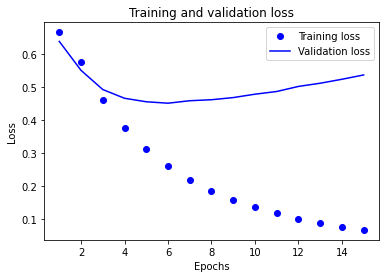

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
Is = layers.Input(shape = (1,), dtype = tf.string)
L1 = vectorize_layer(Is)
L2 = embedding_layer(L1)
L3 = layers.GRU(64,return_sequences=True)(L2)
L4 = layers.GRU(64)(L3)
Os = layers.Dense(1, activation = 'sigmoid')(L4)

model_2 = tf.keras.Model(Is, Os, name = 'GRU_Model')
model_2.summary()

Model: "GRU_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
mbedding_1 (Embedding)       (None, 50, 128)           2560000   
_________________________________________________________________
gru (GRU)                    (None, 50, 64)            37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
_______________________________________________

In [22]:
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)
history_2 = model_2.fit(
    x=trn_tweets,
    y=trn_labels,
    epochs=20,
    validation_data=(val_tweets, val_labels)
)

Epoch 1/20


2022-09-27 23:09:24.341992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


191/191 [==============================] - 6s 12ms/step - loss: 0.6845 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 2/20
191/191 [==============================] - 2s 10ms/step - loss: 0.6844 - accuracy: 0.5695 - val_loss: 0.6836 - val_accuracy: 0.5739
Epoch 3/20
191/191 [==============================] - 2s 9ms/step - loss: 0.6843 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 4/20
191/191 [==============================] - 2s 9ms/step - loss: 0.5531 - accuracy: 0.6911 - val_loss: 0.6609 - val_accuracy: 0.7485
Epoch 5/20
191/191 [==============================] - 2s 9ms/step - loss: 0.1563 - accuracy: 0.9488 - val_loss: 0.6123 - val_accuracy: 0.7617
Epoch 6/20
191/191 [==============================] - 2s 9ms/step - loss: 0.0618 - accuracy: 0.9810 - val_loss: 0.8173 - val_accuracy: 0.7846
Epoch 7/20
191/191 [==============================] - 2s 9ms/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0.9599 - val_accuracy: 0.7715
Epoch 8/20
191/

In [23]:
model_2.evaluate(val_tweets, val_labels)

48/48 [==============================] - 0s 4ms/step - loss: 1.3880 - accuracy: 0.7682


[1.387964129447937, 0.7682206034660339]

In [24]:
predictions = model_2.predict(val_tweets)
predictions = np.round(predictions).flatten()
print(predictions[:10])
accuracy_score(y_true=val_labels, y_pred=predictions)

[0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]


0.768220617202889

In [25]:
history_2_dict = history_2.history
history_2_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

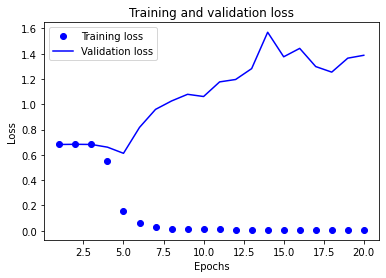

In [26]:
acc = history_2_dict['accuracy']
val_acc = history_2_dict['val_accuracy']
loss = history_2_dict['loss']
val_loss = history_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

tst_predictions = model.predict(tst_tweets)
tst_predictions = np.round(tst_predictions).flatten().astype(int)
print(tst_predictions[:10])

[1 1 1 1 1 1 0 1 0 0]


In [28]:
submission['target'] = tst_predictions

In [29]:
submission.to_csv('submission.csv', index=False)